## NAME: 張子健         Student ID: 103011230
### CS3405 Homework 3         
#### Deep Learning Neural Networks
#### Due: Monday, November 19, 2018

# SUMMARY
## MLP:
### Trainning Accuracy reaches 0.9804 using learning rate= 0.1, batch size=30, activation function=Sigmoid, number of epoch= 500.
* Learning rate=0.1 is a optimal value for [784,50,10] MLP. If learning rate becomes too low, accuracy dramatically decreases. Same phenomenon happens when learning is too high, but different MLP model can have different optimal learning rate.
* Batch Size has significant impact on the trainning time, and it can also influence the trainning accuracy, so we need to find the optimal value with acceptable trainning time and accuracy. In my case, batch size=30 is a good value for MNIST-60000 dataset.
* For activation function, I have tried ReLU, LeakyReLU and sigmoid. Overall, in this MLP model, sigmoid performs better at the result(accuracy).
* Number of epoch will definitely contribute to the trainning accuracy, but it will rach a bottleneck where the accuracy stop increasing.(Other hyperparameters are the factors determining the limit) Since I only have personal laptop and limited time, I choose a set of hyperparameters and trainned it for around 2 hours with my i5-CPU.
## CNN:
### Trainning Accuracy reaches 0.9062 using learning rate= 0.001, batch size=200, activation function=ReLU, number of epoch= 4.
* Learning rate for CNN should be lower than MLP, so I uesd 0.001. If learning rate becomes too low, accuracy dramatically decreases. Same phenomenon happens when learning is too high, but different MLP model can have different optimal learning rate.
* Batch Size has significant impact on the trainning time, and it can also influence the trainning accuracy, so we need to find the optimal value with acceptable trainning time and accuracy. In my case, batch size=500 have been tried but with bad accuracy, so I finally used batch size=200.
* For activation function, I have used ReLU, from the suggestion given by experts on StakeOverFlow.
* Number of epoch will definitely contribute to the trainning accuracy, but it will rach a bottleneck where the accuracy stop increasing.(Other hyperparameters are the factors determining the limit) Since I only have personal laptop and limited time, I choose a set of hyperparameters and trainned it overnight with my i5-CPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# MLP

In [143]:
class MLP():
    def __init__(self, layerlist):
        self.numLayers = len(layerlist)
        self.layers = [{} for i in range(self.numLayers)]
        self.lossList = []
        #np.random.randn : Build a matrix with E(X)=0 and standard deviation=1
        for i in range(1, self.numLayers):
            self.layers[i]["W"] = np.random.randn(layerlist[i], layerlist[i-1])
            self.layers[i]["b"] = np.random.randn(layerlist[i], 1)
        return
            
    def forward(self, x, bs):
        #copy x(input) to self.layers[0]["a"] without modifying x
        self.layers[0]["a"] = np.copy(x)
        for i in range(1, self.numLayers):
            self.layers[i]["z"] = self.layers[i]["W"].dot(self.layers[i-1]["a"]) + self.layers[i]["b"]
            self.layers[i]["a"] = self.activation(self.layers[i]["z"])
        self.p = self.softmax(self.layers[-1]["a"])
        self.y = np.zeros(self.p.shape, dtype=int)
        #
        for j, i in enumerate(self.p.argmax(axis=0)):
            self.y[i, j] = 1
        return
    
    #Sigmoid:  f(x) = 1 / 1 + exp(-x)
    def activation(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    #Hyperbolic Tangent function:  f(x) = 1 — exp(-2x) / 1 + exp(-2x)
    def tanh(self, z):
        return (1-np.exp(-2*z))/(1+np.exp(-2*z))
    
    def ReLU(self, z):
        a = np.copy(z)
        a[a<0] = 0.0
        return a
    
    #Leaky ReLU
    def PReLU(self, z):
        return z if z>0 else z/10
    
    #dadz = inverseActivation
    def inverseActivation(self, a):
        return a * (1.0 - a)
    
    def loss(self, y): 
        return np.mean(- np.log(self.p) * y - np.log(1.0 - self.p) * (1.0 - y) )
    
    # P=softmax(a)
    def softmax(self, a):
        expa = np.exp(a)
        return (expa / np.sum(expa, axis = 0))
    
    def backprop(self, y, bs):
        self.dJdp = - y / self.p + (1.0 - y) / (1.0 - self.p)
        #a 3-dimensional arry
        dpda = np.zeros((self.p.shape[0], self.p.shape[0], bs))
        for b in range(bs):
            for i in range(dpda.shape[0]):
                for j in range(dpda.shape[1]):
                    dpda[i, j, b] = (self.p[i, b] - self.p[i, b] ** 2) if i == j else - self.p[i, b] * self.p[j, b]
        
        self.layers[-1]["dJda"] = np.zeros(self.layers[-1]["a"].shape)
        for b in range(bs):
            self.layers[-1]["dJda"][:, b] = dpda[:, :, b].dot(self.dJdp[:, b])
          
        for i in range(self.numLayers - 1, 0, -1):
            self.layers[i]["dJdz"] = self.inverseActivation(self.layers[i]["a"]) * self.layers[i]["dJda"]
            self.layers[i]["dJdb"] = np.mean(self.layers[i]["dJdz"], axis = 1).reshape(self.layers[i]["b"].shape) #?
            self.layers[i]["dJdW"] = self.layers[i]["dJdz"].dot(self.layers[i-1]["a"].T) / bs #?
            self.layers[i-1]["dJda"] = self.layers[i]["W"].T.dot(self.layers[i]["dJdz"])
        return
            
    def update(self, lr = 0.01):
        for i in range(1, self.numLayers):
            self.layers[i]["W"] -= lr * self.layers[i]["dJdW"]
            self.layers[i]["b"] -= lr * self.layers[i]["dJdb"]
        return
    #a, b = 1-dimensional array
    def shuffle(self, a, b):
        shuffled_a = np.copy(a)
        shuffled_b = np.copy(b)
        permutation = np.random.permutation(a.shape[1])
        #permutation = a number with size equal to the length of a. e.g. batch size
        for oldindex, newindex in enumerate(permutation):
            shuffled_a[:, oldindex] = a[:, newindex]
            shuffled_b[:, oldindex] = b[:, newindex]
        return shuffled_a, shuffled_b
        
    def train(self, trainX, trainY, numEpoch=1, lr=0.01, bs=2):  
        for e in range(numEpoch):
            shuffled_trainX, shuffled_trainY = self.shuffle(trainX, trainY)
            for i in range(trainX.shape[1] // bs):
                #冒號：指定範圍, from ith batch to (i+1) batch
                x = shuffled_trainX[:, i*bs : (i+1)*bs]
                y = shuffled_trainY[:, i*bs : (i+1)*bs]
                self.forward(x, bs)
                self.lossList.append(self.loss(y))  #?
                self.backprop(y, bs)
                self.update(lr)
        return

In [158]:
def csv2xy(fileName):
    f = open(fileName, "r")
    a = f.readlines()
    f.close()

    x = []
    y = []

    for line in a:
        linepixels = [int(pixel) for pixel in line.split(",")]
        x.append(linepixels[1:])
        y.append(linepixels[0])
    
    
    out_x = np.clip(np.array(x).T, 0, 1)
    out_y = np.zeros((10, len(y)), dtype=int)
    for i in range(len(y)):
        out_y[y[i], i] = 1
        
    return out_x, out_y
    
train_x_60000, train_y_60000 = csv2xy("mnist_train_60000.csv")
test_x_10000, test_y_10000 = csv2xy("mnist_test_10000.csv")
train_x_100, train_y_100 = csv2xy("mnist_train_100.csv")
test_x_10, test_y_10 = csv2xy("mnist_test_10.csv")

In [165]:
nnMNIST60000 = MLP([784, 50, 10])

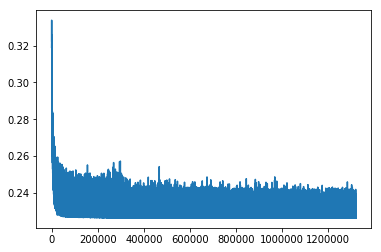

In [188]:
nnMNIST60000.train(train_x_60000, train_y_60000, numEpoch=100, lr=0.1, bs = 30)
plt.plot(nnMNIST60000.lossList)

In [189]:
nnMNIST60000.forward(train_x_60000, 60000)
predicted = nnMNIST60000.y.argmax(axis=0)
answer = train_y_60000.argmax(axis=0)
accuracy = 1.0 - float(len(np.nonzero(predicted - answer)[0])) / len(answer)
print ("Training Accuracy=", accuracy)

Training Accuracy= 0.9804333333333334


# CNN

In [205]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload-images.jianshu.io/upload_images/1817489-8a396b10074d0750.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1000")

In [195]:
def glorot_uniform(shape, num_neurons_in, num_neurons_out):
    scale = np.sqrt(6. / (num_neurons_in + num_neurons_out))
    return np.random.uniform(low=-scale, high=scale, size=shape)

def zero(shape, *args):
    return np.zeros(shape)
### activations ################################################################
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def der_sigmoid(x, y=None):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

def der_softmax(x, y=None):
    s = softmax(x)
    if y is not None:
        k = s[np.where(y == 1)]
        a = - k * s
        a[np.where(y == 1)] = k * (1 - k)
        return a
    return s * (1 - s)

    def ReLU(self, z):
        a = np.copy(z)
        a[a<0] = 0.0
        return a
    
    def ReLUPrime(self, a):
        dadz = np.copy(a)
        dadz[a>0] = 1.0
        return dadz
    
    def LeakyReLU(self, z, leakyrate):
        a = np.copy(z)
        (rows, cols) = a.shape
        for i in range(rows):
            for j in range(cols):
                a[i, j] = z[i, j] if z[i,j] > 0 else (leakyrate * z[i, j])
        return a

In [197]:
class Layer(metaclass=abc.ABCMeta):
    def __init__(self):
        self.depth = None
        self.height = None
        self.width = None
        self.n_out = None
        self.w = None
        self.b = None

    @abc.abstractmethod
    def connect_to(self, prev_layer):
        raise AssertionError

    @abc.abstractmethod
    def feedforward(self, prev_layer):
        raise AssertionError

    @abc.abstractmethod
    def backpropagate(self, prev_layer, delta):
        raise AssertionError


class InputLayer(Layer):
    def __init__(self, height, width):
        super().__init__()
        self.depth = 1
        self.height = height
        self.width = width
        self.n_out = self.depth * self.height * self.width
        self.der_act_func = lambda x: x

    def connect_to(self, prev_layer):
        raise AssertionError

    def feedforward(self, prev_layer):
        raise AssertionError

    def backpropagate(self, prev_layer, delta):
        raise AssertionError


class FullyConnectedLayer(Layer):
    def __init__(self, height, init_func, act_func):
        super().__init__()
        self.depth = 1
        self.height = height
        self.width = 1
        self.n_out = self.depth * self.height * self.width
        self.init_func = init_func
        self.act_func = act_func
        self.der_act_func = getattr(f, "der_%s" % act_func.__name__)

    def connect_to(self, prev_layer):
        self.w = self.init_func((self.n_out, prev_layer.n_out), prev_layer.n_out, self.n_out)
        self.b = f.zero((self.n_out, 1))

    def feedforward(self, prev_layer):
        """
        Feedforward the observation through the layer

        :param prev_layer: the previous layer of the network
        """
        prev_a = prev_layer.a.reshape((prev_layer.a.size, 1))

        self.z = (self.w @ prev_a) + self.b

        self.a = self.act_func(self.z)
        assert self.z.shape == self.a.shape

    def backpropagate(self, prev_layer, delta):
        """
        Backpropagate the error through the layer

        :param prev_layer: the previous layer of the network
        :param delta: the error propagated backward by the next layer of the network
        :returns: the amount of change of input weights of this layer, the amount of change of the biases of this layer
            and the error propagated by this layer
        """
        assert delta.shape == self.z.shape == self.a.shape

        prev_a = prev_layer.a.reshape((prev_layer.a.size, 1))

        der_w = delta @ prev_a.T

        der_b = np.copy(delta)

        prev_delta = (self.w.T @ delta).reshape(prev_layer.z.shape) * prev_layer.der_act_func(prev_layer.z)

        return der_w, der_b, prev_delta


class ConvolutionalLayer(Layer):
    def __init__(self, depth, kernel_size, init_func, act_func):
        super().__init__()
        self.depth = depth
        self.kernel_size = kernel_size
        self.init_func = init_func
        self.act_func = act_func
        self.der_act_func = getattr(f, "der_%s" % act_func.__name__)

    def connect_to(self, prev_layer):
        self.stride_length = 1
        self.height = ((prev_layer.height - self.kernel_size) // self.stride_length) + 1
        self.width  = ((prev_layer.width  - self.kernel_size) // self.stride_length) + 1
        self.n_out = self.depth * self.height * self.width

        self.w = self.init_func((self.depth, prev_layer.depth, self.kernel_size, self.kernel_size),
            prev_layer.n_out, self.n_out)
        self.b = f.zero((self.depth, 1))

    def feedforward(self, prev_layer):
        """
        Feedforward the observation through the layer

        :param prev_layer: the previous layer of the network. The activations of the previous layer must be a list of
            feature maps, where each feature map is a 2d matrix
        """
        assert self.w.shape == (self.depth, prev_layer.depth, self.kernel_size, self.kernel_size)
        assert self.b.shape == (self.depth, 1)
        assert prev_layer.a.ndim == 3

        prev_a = prev_layer.a

        filters_c_out = self.w.shape[0]
        filters_c_in = self.w.shape[1]
        filters_h = self.w.shape[2]
        filters_w = self.w.shape[3]

        image_c = prev_a.shape[0]
        assert image_c == filters_c_in
        image_h = prev_a.shape[1]
        image_w = prev_a.shape[2]

        stride = 1
        new_h = ((image_h - filters_h) // stride) + 1
        new_w = ((image_w - filters_w) // stride) + 1

        self.z = np.zeros((filters_c_out, new_h, new_w))
        for r in range(filters_c_out):
            for t in range(image_c):
                filter = self.w[r, t]
                for i, m in enumerate(range(0, image_h - filters_h + 1, self.stride_length)):
                    for j, n in enumerate(range(0, image_w - filters_w + 1, self.stride_length)):
                        prev_a_window = prev_a[t, m:m+filters_h, n:n+filters_w]
                        self.z[r, i, j] += np.correlate(prev_a_window.ravel(), filter.ravel(), mode="valid")

        for r in range(self.depth):
            self.z[r] += self.b[r]

        self.a = np.vectorize(self.act_func)(self.z)
        assert self.a.shape == self.z.shape

    def backpropagate(self, prev_layer, delta):
        """
        Backpropagate the error through the layer

        :param prev_layer: the previous layer of the network. The activations of the previous layer are a list of
            feature maps, where each feature map is a 2d matrix
        :param delta:
        """
        assert delta.shape[0] == self.depth

        prev_a = prev_layer.a

        der_w = np.empty_like(self.w)
        for r in range(self.depth):
            for t in range(prev_layer.depth):
                for h in range(self.kernel_size):
                    for v in range(self.kernel_size):
                        prev_a_window = prev_a[t, v:v+self.height-self.kernel_size+1:self.stride_length,
                                                  h:h+self.width -self.kernel_size+1:self.stride_length]
                        delta_window  =  delta[r, v:v+self.height-self.kernel_size+1:self.stride_length,
                                                  h:h+self.width -self.kernel_size+1:self.stride_length]
                        assert prev_a_window.shape == delta_window.shape
                        der_w[r, t, h, v] = np.sum(prev_a_window * delta_window)

        der_b = np.empty((self.depth, 1))
        for r in range(self.depth):
            der_b[r] = np.sum(delta[r])

        prev_delta = np.zeros_like(prev_a)
        for r in range(self.depth):
            for t in range(prev_layer.depth):
                kernel = self.w[r, t]
                for i, m in enumerate(range(0, prev_layer.height - self.kernel_size + 1, self.stride_length)):
                    for j, n in enumerate(range(0, prev_layer.width - self.kernel_size + 1, self.stride_length)):
                        prev_delta[t, m:m+self.kernel_size, n:n+self.kernel_size] += kernel * delta[r, i, j]
        prev_delta *= prev_layer.der_act_func(prev_layer.z)

        return der_w, der_b, prev_delta


class MaxPoolingLayer(Layer):
    def __init__(self, pool_size):
        super().__init__()
        self.pool_size = pool_size
        self.der_act_func = lambda x: x

    def connect_to(self, prev_layer):
        assert isinstance(prev_layer, ConvolutionalLayer)
        self.depth = prev_layer.depth
        self.height = ((prev_layer.height - self.pool_size) // self.pool_size) + 1
        self.width  = ((prev_layer.width  - self.pool_size) // self.pool_size) + 1
        self.n_out = self.depth * self.height * self.width

        self.w = np.empty((0))
        self.b = np.empty((0))

    def feedforward(self, prev_layer):
        """
        Feedforward the observation through the layer

        :param prev_layer: the previous layer of the network. The activations of the previous layer must be a list of
            feature maps, where each feature map is a 3d matrix
        """
        assert self.w.size == 0
        assert self.b.size == 0
        assert isinstance(prev_layer, ConvolutionalLayer)
        assert prev_layer.depth == self.depth
        assert prev_layer.a.ndim == 3

        prev_a = prev_layer.a

        prev_layer_fmap_size = prev_layer.height
        assert prev_layer_fmap_size % self.pool_size == 0

        self.z = np.zeros((self.depth, self.height, self.width))
        for r, t in zip(range(self.depth), range(prev_layer.depth)):
            assert r == t
            for i, m in enumerate(range(0, prev_layer.height, self.pool_size)):
                for j, n in enumerate(range(0, prev_layer.width, self.pool_size)):
                    prev_a_window = prev_a[t, m:m+self.pool_size, n:n+self.pool_size]
                    assert prev_a_window.shape == (self.pool_size, self.pool_size)
                    # downsampling
                    self.z[r, i, j] = np.max(prev_a_window)

        self.a = self.z

    def backpropagate(self, prev_layer, delta):
        """
        Backpropagate the error through the layer. Given any pair source(convolutional)/destination(pooling) feature
        maps, each unit of the destination feature map propagates an error to a window (self.pool_size, self.pool_size)
        of the source feature map

        :param prev_layer: the previous layer of the network
        :param delta: a tensor of shape (self.depth, self.height, self.width)
        """
        assert self.w.size == 0
        assert self.b.size == 0
        assert isinstance(prev_layer, ConvolutionalLayer)
        assert prev_layer.depth == self.depth
        assert prev_layer.a.ndim == 3
        assert delta.shape == (self.depth, self.height, self.width)

        prev_a = prev_layer.a

        der_w = np.array([])

        der_b = np.array([])

        prev_delta = np.empty_like(prev_a)
        for r, t in zip(range(self.depth), range(prev_layer.depth)):
            assert r == t
            for i, m in enumerate(range(0, prev_layer.height, self.pool_size)):
                for j, n in enumerate(range(0, prev_layer.width, self.pool_size)):
                    prev_a_window = prev_a[t, m:m+self.pool_size, n:n+self.pool_size]
                    assert prev_a_window.shape == (self.pool_size, self.pool_size)
                    # upsampling: the unit which was the max at the forward propagation
                    # receives all the error at backward propagation (the other units receive zero)
                    max_unit_index = np.unravel_index(prev_a_window.argmax(), prev_a_window.shape)
                    prev_delta_window = np.zeros_like(prev_a_window)
                    prev_delta_window[max_unit_index] = delta[t, i, j]
                    prev_delta[r, m:m+self.pool_size, n:n+self.pool_size] = prev_delta_window

        return der_w, der_b, prev_delta


In [1]:
class NeuralNetwork():
    def __init__(self, layers, loss_func):
        assert len(layers) > 0

        assert isinstance(layers[0], l.InputLayer)
        self.input_layer = layers[0]

        assert isinstance(layers[-1], l.FullyConnectedLayer)
        self.output_layer = layers[-1]

        self.layers = [(prev_layer, layer) for prev_layer, layer in zip(layers[:-1], layers[1:])]

        self.loss_func = loss_func

        for prev_layer, layer in self.layers:
            layer.connect_to(prev_layer)

    def feedforward(self, x):
        self.input_layer.z = x
        self.input_layer.a = x

        for prev_layer, layer in self.layers:
            layer.feedforward(prev_layer)

    def backpropagate(self, batch, optimizer):
        sum_der_w = {layer: np.zeros_like(layer.w) for _, layer in self.layers}
        sum_der_b = {layer: np.zeros_like(layer.b) for _, layer in self.layers}

        for x, y in batch:
            self.feedforward(x)

            # propagate the error backward
            loss = self.loss_func(self.output_layer.a, y)
            delta = loss * self.output_layer.der_act_func(self.output_layer.z, y)
            for prev_layer, layer in reversed(self.layers):
                der_w, der_b, prev_delta = layer.backpropagate(prev_layer, delta)
                sum_der_w[layer] += der_w
                sum_der_b[layer] += der_b
                delta = prev_delta

        # update weights and biases
        optimizer.apply(self.layers, sum_der_w, sum_der_b, len(batch))


def train(net, optimizer, num_epochs, batch_size, trn_set, vld_set=None):
    assert isinstance(net, NeuralNetwork)
    assert num_epochs > 0
    assert batch_size > 0

    trn_x, trn_y = trn_set
    inputs = [(x, y) for x, y in zip(trn_x, trn_y)]

    for i in range(num_epochs):
        np.random.shuffle(inputs)

        # divide input observations into batches
        batches = [inputs[j:j+batch_size] for j in range(0, len(inputs), batch_size)]
        inputs_done = 0
    for i in range(total_iters):
        workspace.RunNet(train_model.net)
        accuracy[i] = workspace.blobs['accuracy']
        loss[i] = workspace.blobs['loss']
        # Check the accuracy and loss every so often
        if i % 25 == 0:
            print("Epoch: {}, Loss: {}, Accuracy: {}".format(i,loss[i],accuracy[i]))

BatchSize = 200
EpochCount = 4
LearningRate = 0.001
Eta = 0.001

input_data_spec = [BatchSize, 1, 28, 28] 
conv_layer_spec = [{"k_num" : 6, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 16, "k_h" : 3, "k_w" : 3, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]
fc_layer_spec = [400,120,84,10]

cnn60000 = CNN(input_data_spec=input_data_spec, 
          conv_layer_spec=conv_layer_spec, 
          fc_layer_spec=fc_layer_spec)

cnn60000.train(train_60000_x, train_60000_y,train_60000_x, train_60000_y, EpochCount, LearningRate, Eta)
cnn60000.train(train_60000_x, train_60000_y, EpochCount, LearningRate, Eta)

Epoch: 1, Loss: 1.41657829285, Accuracy: 0.73125
Epoch: 2, Loss: 0.419774413109, Accuracy: 0.875
Epoch: 3, Loss: 0.313294112682, Accuracy: 0.890625
Epoch: 4, Loss: 0.285170167685, Accuracy: 0.90625
